In [1]:
#imports
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Sequential
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of

def taglia_e_cuci(v):
    hi=np.quantile(v,0.005)
    lo=np.quantile(v, 0.995)
    b=np.clip(v, hi,lo)
    return b

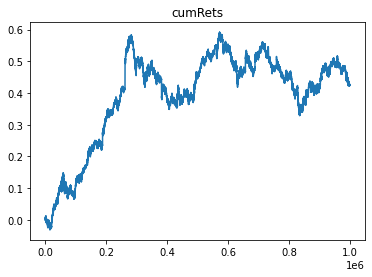

In [3]:
#load data e fa midprice/diff cum
lob_data=pd.read_csv('/Users/macri/Desktop/PROJECT/out_Nuovo.csv') #out_1 out_Nuovo
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['Unnamed: 0'], axis=1,inplace=True)
C= int(len(lob_data)*1/4)
b=lob_data.iloc[ :1000006].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])#.plot()
m['r']=m['m'].pct_change()#()#calcola le differenze di midprice ogni 10 eventi ->differenze secondo il vettore h_K
m['rCum']=m['r'].cumsum()
of_data['r']=m['rCum']#*100
of_data.dropna(inplace=True)
of_data['r'].plot()
plt.title('cumRets')
plt.show()

In [4]:
offlo=of_data.apply(lambda x: taglia_e_cuci(x))

In [13]:
#fa dataset
y=offlo['r'].to_numpy()
idx=10000
horiz=1
r=np.empty((idx,horiz))
med=np.empty((idx,horiz))
h=[ 22]#, 44, 89, 133, 178, 223, 267, 312, 356, 401]

for i in range(idx): #righe
    for ii,iii in zip(range(horiz),h): #colonne, steps
        r[i,ii]=y[i+iii]-y[i]
        med[i][ii]=np.mean(y[:i+iii])

x_vec=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:1000000]
x=x_vec.to_numpy()
x_vecc=x.reshape(-1,100, 6)
erre=r

r.shape, x_vecc.shape, med.shape

((10000, 1), (10000, 100, 6), (10000, 1))

In [14]:
##fa supervised dataset: train, val e test
#l=len(x_vecc)
#a=int(9000)
#b=int(999)
#x_vecc_train=x_vecc[:a]
#r_train     =r[:a]
#x_vecc_val  =x_vecc[a:a+b]
#r_val       =r[a:a+b]
#x_vecc_test =x_vecc[a+b:a+b+1]
#r_test      =r[a+b:a+b+1]
#print(x_vecc_train.shape, r_train.shape)
#print(x_vecc_val.shape,   r_val.shape)
#print(x_vecc_test.shape,  r_test.shape)
#
#fa supervised dataset: train, val e test
l=len(x_vecc)
a=int(9000)
b=int(999)
x_vecc_train=x_vecc[:a]

mu=x_vecc_train.mean()
sd=x_vecc_train.std()
stdize=lambda x: x/sd


x_vecc_train=x_vecc[:a]/sd
r_train     =r[:a]
x_vecc_val  =x_vecc[a:a+b]/sd
r_val       =r[a:a+b]
x_vecc_test =x_vecc[a+b:a+b+1]/sd
r_test      =r[a+b:a+b+1]


#fflo=of_data.apply(lambda x: (x-x.mean())/x.std())
print(x_vecc_train.shape, r_train.shape)
print(x_vecc_val.shape,   r_val.shape)
print(x_vecc_test.shape,  r_test.shape)


(9000, 100, 6) (9000, 1)
(999, 100, 6) (999, 1)
(1, 100, 6) (1, 1)


In [15]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'mse'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.5)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='leaky_relu')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function)

r=model.fit(x_vecc_train, r_train, batch_size = batch_size, epochs = num_epochs,validation_data=(x_vecc_val, r_val),callbacks=[callback])

Epoch 1/50
36/36 [==============================] - 10s 245ms/step - loss: 3.1694e-04 - val_loss: 1.5208e-04
Epoch 2/50
36/36 [==============================] - 9s 242ms/step - loss: 1.0778e-04 - val_loss: 8.8791e-05
Epoch 3/50
36/36 [==============================] - 9s 243ms/step - loss: 7.2776e-05 - val_loss: 6.5061e-05
Epoch 4/50
36/36 [==============================] - 9s 251ms/step - loss: 5.6637e-05 - val_loss: 5.2466e-05
Epoch 5/50
36/36 [==============================] - 9s 239ms/step - loss: 4.8579e-05 - val_loss: 4.7914e-05
Epoch 6/50
36/36 [==============================] - 10s 289ms/step - loss: 4.1944e-05 - val_loss: 4.5926e-05
Epoch 7/50
36/36 [==============================] - 10s 285ms/step - loss: 3.9518e-05 - val_loss: 3.9021e-05
Epoch 8/50
36/36 [==============================] - 10s 284ms/step - loss: 3.5427e-05 - val_loss: 3.6286e-05
Epoch 9/50
36/36 [==============================] - 10s 287ms/step - loss: 3.2808e-05 - val_loss: 3.3802e-05
Epoch 10/50
36/36 [====

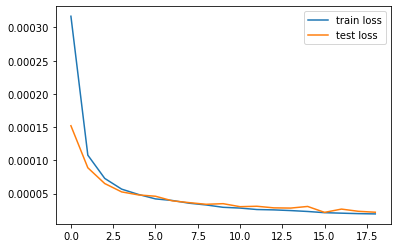

In [19]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [20]:
Ptrain= model.predict(x_vecc_train)
Ptest = model.predict(x_vecc_test)


1/1 [==============================] - 0s 16ms/step


In [26]:
true=r_test#normalizer.inverse_transform(r_test.reshape(-1,1)).flatten()
fcst=Ptest#normalizer.inverse_transform(Ptest.reshape(-1,1)).flatten()
u=np.array([np.mean(true)]*10).flatten()
num=(true-fcst)**2
den=(erre[0][-1:].flatten()-med[0])**2
r2OutS=((den-num)/den)#/100
r2OutS
#plt.plot(r2OutS[0])
#plt.ylabel('R2OS(%)')
#plt.xlabel('time');

array([[0.93058332]])

In [27]:
r2OutS

array([[0.93058332]])

In [12]:
#from sklearn.metrics import mean_squared_error as me
#def calcola_mse(y_true,y_pred):
#    ms=np.zeros(10)
#    for i in range(10):
#        ms[i]=me(y_true[0][:i+1],y_pred[0][:i+1])
#    return ms
#num=calcola_mse(r_test,Ptest)
#den=calcola_mse(r_train,Ptrain)
#r2LSTM=1-(num/den)
#r2LSTM.flatten()
#plt.plot(r2LSTM);